In [19]:
%matplotlib inline

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display_markdown as mkdown # as print

def nl():
    print('\n')

for f in os.listdir('raw'):
    if f.find('.zip') < 0:
        print(f.ljust(30) + str(round(os.path.getsize('raw/' + f) / 1000000, 2)) + 'MB')

cliente_tabla.csv             21.25MB
train.csv                     3199.36MB
test.csv                      251.11MB
producto_tabla.csv            0.11MB
sample_submission.csv         68.88MB
town_state.csv                0.03MB


It looks like we are given quite a few sets as an input! Let's take a look at each one, starting with train and test.

In [29]:
df_train = pd.read_csv('raw/train.csv', nrows=500000)
df_test = pd.read_csv('raw/test.csv', nrows=500000)

nl()
print('Size of training set: ' + str(df_train.shape))
print(' Size of testing set: ' + str(df_test.shape))

nl()
print('Columns in train: ' + str(df_train.columns.tolist()))
print(' Columns in test: ' + str(df_test.columns.tolist()))

nl()
print(df_train.describe())



Size of training set: (500000, 11)
 Size of testing set: (500000, 7)


Columns in train: ['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima', 'Demanda_uni_equil']
 Columns in test: ['id', 'Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID']


         Semana     Agencia_ID       Canal_ID       Ruta_SAK    Cliente_ID  \
count  500000.0  500000.000000  500000.000000  500000.000000  5.000000e+05   
mean        3.0    1115.814010       1.118138    1590.864712  1.198001e+06   
std         0.0       3.127955       0.823334     801.433471  1.462295e+06   
min         3.0    1110.000000       1.000000       1.000000  3.967000e+03   
25%         3.0    1112.000000       1.000000    1109.000000  1.098650e+05   
50%         3.0    1117.000000       1.000000    1447.000000  5.137590e+05   
75%         3.0    1118.000000       1.000000    1606.000000  1.793000e+06   
max         3.0   

`Demanda_uni_equil` is the target value that we are trying to predict.

Let's take a look at the distribution:

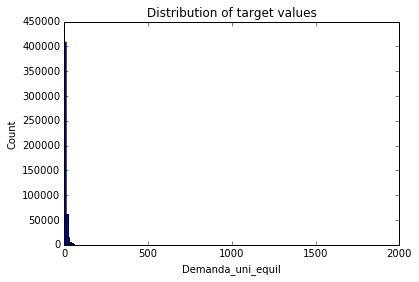

Looks like we have some pretty big outliers, let's zoom in and try again
Data with target values under 50: 99.12%


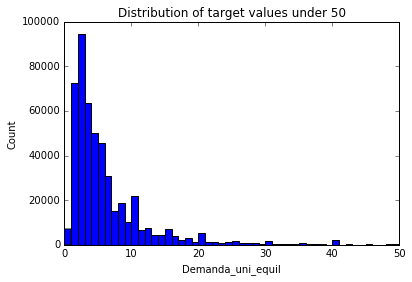

In [35]:
target = df_train['Demanda_uni_equil'].tolist()

def label_plot(title, x, y):
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

plt.hist(target, bins=200, color='blue')
label_plot('Distribution of target values', \
           'Demanda_uni_equil', 'Count')
plt.show()

print("Looks like we have some pretty big outliers, " + \
      "let's zoom in and try again")

print('Data with target values under 50: ' + \
      str(round(len(df_train.loc[df_train['Demanda_uni_equil'] <= 50]) / \
                5000, 2)) + '%')

plt.hist(target, bins=50, color='blue', range=(0, 50))
label_plot('Distribution of target values under 50', \
           'Demanda_uni_equil', 'Count')
plt.show()


From this distribution, we can see that some target values are much more common than others.

Let's find the mode of the target and make a naive submission using that!

In [36]:
from collections import Counter
print(Counter(target).most_common(10))
print('Our most common value is 2')

sub = pd.read_csv('raw/sample_submission.csv')
sub['Demanda_uni_equil'] = 2
sub.to_csv('mostcommon.csv', index=False)

[(2, 94328), (1, 72617), (3, 63437), (4, 50169), (5, 45632), (6, 30941), (10, 21816), (8, 18958), (7, 15252), (9, 10304)]
Our most common value is 2


Interestingly, our script (0.96080) performs worse than submitting `6` as the predicted value. This could be for two reasons:

1) Our values are incorrect since we have only read the first 500,000 values of the dataset and the set is not randomised.  
2) Due to the [evaluation metric](https://www.kaggle.com/c/grupo-bimbo-inventory-demand/details/evaluation) predicting 6 actually gives a lower overall logarithmic error.

We will begin by investigating the first possibility, and will look at whether the time-series has any effect on data.

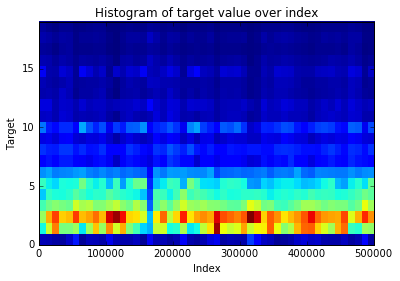

In [43]:
pseudo_time = df_train.loc[df_train.Demanda_uni_equil < 20].index.tolist()
target = df_train.loc[df_train.Demanda_uni_equil < 20].Demanda_uni_equil.tolist()

plt.hist2d(pseudo_time, target, bins=[50,20])
label_plot('Histogram of target value over index', 'Index', 'Target')
plt.show()

It does not look like the time-series has much effect on the data, except for that anomaly around 200k (we may take a closer look at another time)

Now that we have found the best naive submission to make, we can go onto looking at the other columns!

We will begin by looking at the time column, semana (meaning week)

3    500000
Name: Semana, dtype: int64

It looks like by sampling only the first 500,000 columns, we have only sampled from week 3.
We will have to take a larger portion of the dataset

Size: (74180464, 2)
3    11165207
4    11009593
5    10615397
9    10408713
8    10406868
7    10382849
6    10191837
Name: Semana, dtype: int64


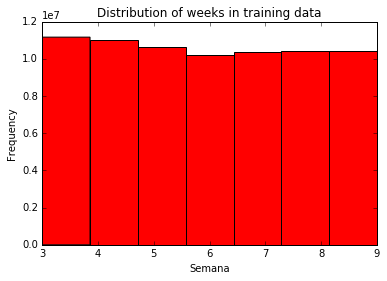

10    3538385
11    3460866
Name: Semana, dtype: int64


In [17]:
semana = df_train['Semana']
print(semana.value_counts())
print('\nIt looks like by sampling only the first 500,000 columns, we have only sampled from week 3.\nWe will have to take a larger portion of the dataset\n')

timing = pd.read_csv('raw/train.csv', usecols=['Semana','Demanda_uni_equil'])
print('Size: ' + str(timing.shape))

print(timing['Semana'].value_counts())
plt.hist(timing['Semana'].tolist(), bins=7, color='red')
label_plot('Distribution of weeks in training data', 'Semana', 'Frequency')
plt.show()

timing_test = pd.read_csv('raw/test.csv', usecols=['Semana'])
print(timing_test['Semana'].value_counts())

We have a different set of weeks in the testing data for us to predict - meaning that this is likely a time series prediction problem for each of the product/client/location pairs in train and test sets.

Since this appears to be a time series prediction task, let's see if there are any trends in the target value over time.

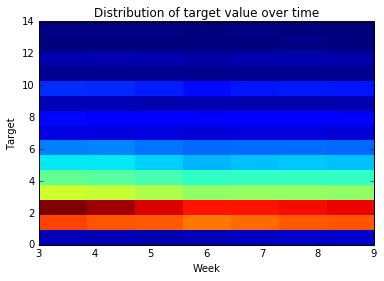

In [16]:
timing = timing.sample(1000000)
timing = timing.loc[timing['Demanda_uni_equil'] < 15] # We only want to look at the most common values

plt.hist2d(timing['Semana'].tolist(), timing['Demanda_uni_equil'].tolist(), bins=[7, 15])
label_plot('Distribution of target value over time', 'Week', 'Target')
plt.show()